## Data Cleaning

### Data Gaps
As a first step, we need to ensure that the data is consistent, i.e., that there are no significant gaps. As we can see we have no data entries between May 15 th 2023 and December 29th 2023.

In [416]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta

# ticks
df_eth = pd.read_csv("./data/historical_candles_HL/eth_candles.csv").sort_values(by="date_open")
df_btc = pd.read_csv("./data/historical_candles_HL/btc_candles.csv").sort_values(by="date_open")
df_sol = pd.read_csv("./data/historical_candles_HL/sol_candles.csv").sort_values(by="date_open")

# funding
eth_funding = pd.read_csv("./data/historical_funding_HL/eth_funding_rates.csv").sort_values(by="date")
btc_funding = pd.read_csv("./data/historical_funding_HL/btc_funding_rates.csv").sort_values(by="date")
sol_funding = pd.read_csv("./data/historical_funding_HL/sol_funding_rates.csv").sort_values(by="date")

# orderbook
eth_orderbook = pd.read_csv("./data/historical_orderbooks_HL/eth_orderbook.csv").sort_values(by="date")
btc_orderbook = pd.read_csv("./data/historical_orderbooks_HL/btc_orderbook.csv").sort_values(by="date")
sol_orderbook = pd.read_csv("./data/historical_orderbooks_HL/sol_orderbook.csv").sort_values(by="date")

# find gaps in data by resampling
df_eth_time_index = df_eth.set_index(pd.DatetimeIndex(df_eth["date_close"]))
df_eth_resample = df_eth_time_index["close"].resample("1D").last().reset_index(name="last")
empty_eth = df_eth_resample.loc[df_eth_resample["last"].isna()]

df_btc_time_index = df_btc.set_index(pd.DatetimeIndex(df_btc["date_close"]))
df_btc_resample = df_btc_time_index["close"].resample("1D").last().reset_index(name="last")
empty_btc = df_btc_resample.loc[df_btc_resample["last"].isna()]

df_sol_time_index = df_sol.set_index(pd.DatetimeIndex(df_sol["date_close"]))
df_sol_resample = df_sol_time_index["close"].resample("1D").last().reset_index(name="last")
empty_sol = df_sol_resample.loc[df_sol_resample["last"].isna()]

# combined 
pd.merge(empty_eth, empty_btc, on="date_close").merge(empty_sol, on="date_close")

,date_close,last_x,last_y,last
0,2023-05-15,NaN,NaN,NaN
1,2023-05-16,NaN,NaN,NaN
2,2023-05-17,NaN,NaN,NaN
3,2023-05-18,NaN,NaN,NaN
4,2023-05-19,NaN,NaN,NaN
...,...,...,...,...
224,2023-12-25,NaN,NaN,NaN
225,2023-12-26,NaN,NaN,NaN
226,2023-12-27,NaN,NaN,NaN
227,2023-12-28,NaN,NaN,NaN


### Data Entries

Next, we want to ensure that the tick data is consistent amongst the remaining data. We group the tick data by data and see that for Solana there are inconsistencies for December 30th and February 21st. For that reason we will be working with data from December 31st to February 20th.

In [417]:
df_eth_entries = df_eth.groupby(pd.to_datetime(df_eth["date_close"]).dt.floor("d"))["close"].count().reset_index(name="count_eth")
df_btc_entries = df_btc.groupby(pd.to_datetime(df_btc["date_close"]).dt.floor("d"))["close"].count().reset_index(name="count_btc")
df_sol_entries = df_sol.groupby(pd.to_datetime(df_sol["date_close"]).dt.floor("d"))["close"].count().reset_index(name="count_sol")

# combined
df_merged = pd.merge(df_eth_entries, df_btc_entries, on="date_close").merge(df_sol_entries, on="date_close")
df_merged["eq"] = df_merged.apply(lambda x: x.count_eth == x.count_btc == x.count_sol, axis=1)
df_merged.loc[df_merged["eq"]==False]

,date_close,count_eth,count_btc,count_sol,eq
3,2023-12-30,41,41,37,False
56,2024-02-21,3,3,5,False


## Data Analysis

### Correlation and Co-Integration

Now that we have our working data set, we can implement the trading strategy. First, we will check for correlations amongst the pairs and see that BTC&SOL are highly correlated.

In [418]:
# cut off data
df_eth = df_eth[(pd.to_datetime(df_eth["date_open"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(df_eth["date_close"]) < dt.datetime(2024, 2, 21))].reset_index()
df_btc = df_btc[(pd.to_datetime(df_btc["date_open"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(df_btc["date_close"]) < dt.datetime(2024, 2, 21))].reset_index()
df_sol = df_sol[(pd.to_datetime(df_sol["date_open"]) > dt.datetime(2023, 12, 31)) & (pd.to_datetime(df_sol["date_close"]) < dt.datetime(2024, 2, 21))].reset_index()

prices_combined = pd.concat([df_eth["close"], df_btc["close"], df_sol["close"]], axis=1, ignore_index=True)
prices_combined.columns = [["eth_close", "btc_close", "sol_close"]]

corr_matrix = prices_combined.corr()
corr_matrix

,eth_close,btc_close,sol_close
eth_close,1.000000,0.803223,0.648805
btc_close,0.803223,1.000000,0.859498
sol_close,0.648805,0.859498,1.000000


### Co-Integration

To really establish a relationship between two time series, we will be investigating whether any of the pairs are co-integrated. Given that prices by themselves are non-stationary, we will be looking at the spread which we define as $$spread = log(a) - nlog(b)$$

We see that based on the 15-minute data, SOL and BTC are co-integrated.

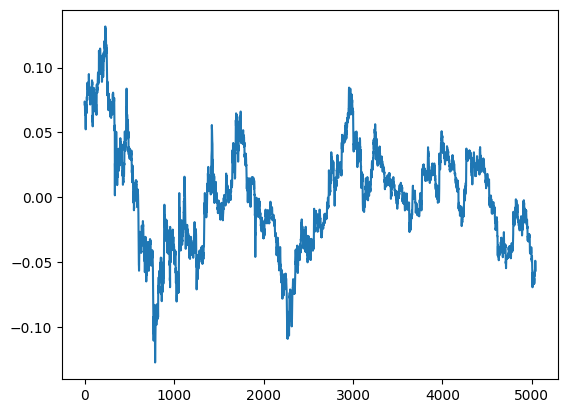

p-value: 0.013680699073663823, test statistic: -3.3277984285121147


In [419]:
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from scipy.stats import zscore
import statsmodels.api as sm
import seaborn

# investigate the spread between the logs

# run pairwise cointegration test
def cointegrated_pairs(data):
    n = data.shape[1]
    scores = np.zeros((n, n))
    p_values = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            scores[i, j] = score
            p_values[i, j] = pvalue
            print(p_values)
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return(scores, p_values, pairs)

# run cointegration on data
# scores, p_values, pairs = cointegrated_pairs(prices_combined)
# seaborn.heatmap(p_values, xticklabels=["ETH", "BTC", "SOL"], yticklabels=["ETH", "BTC", "SOL"], cmap='RdYlGn_r', mask=(p_values>=0.05))

# set log of price for all three currencies
df_eth["log_close"] = np.log(df_eth["close"])
df_btc["log_close"] = np.log(df_btc["close"])
df_sol["log_close"] = np.log(df_sol["close"])

Y = df_sol["log_close"]
X = df_btc["log_close"]

X = sm.add_constant(X)

model = sm.OLS(Y, X)
results = model.fit()

alpha = results.params.values[0]
beta = results.params.values[1]
errors = Y - (alpha + X['log_close'] * beta)

errors.plot()
plt.show()

dftest = adfuller(errors, maxlag=1)
print(f"p-value: {dftest[1]}, test statistic: {dftest[0]}")

### Signal Generation

For the signal, we will be looking at the z-score. We can then assess the threshold that we want in order to create the corresponding trading signal. In essence what we are trying to accomplish is to long the spread when the z-score falls below our threshold of 1 and short the spread whenever it 

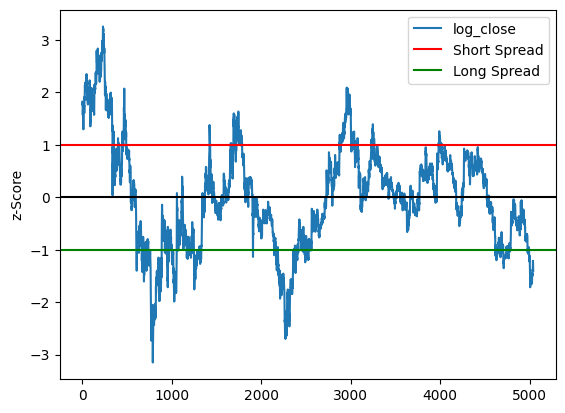

In [420]:
# calculate z score
spread = errors
z = (spread - np.mean(spread))/np.std(spread)
z.plot()
plt.axhline(z.mean(), color="black")
plt.axhline(1.0, color="red", label="Short Spread")
plt.axhline(-1.0, color="green", label="Long Spread")
plt.ylabel("z-Score")
plt.legend()
plt.show()

### Backtesting

Next, we assess the viability of the trading strategy. Based on the above thresholds, the corresponding buy/sell signals would be the following:

* Buy signal (long the spread): when z-score <= -1 
* Sell signal (short the spread): when z-score >= 1

Gross returns amount to 5.8% from January 1st to February 22nd.

<Axes: xlabel='date_close'>

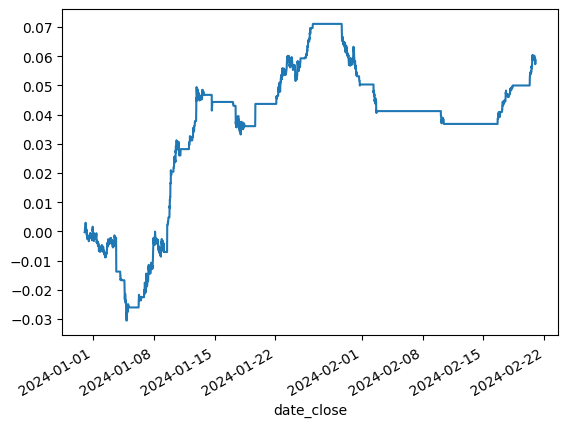

In [421]:
trades = pd.DataFrame()
trades["signal"] = z
trades["pos"] = spread
trades["side"] = 0.0

trades.loc[trades["signal"] <= -1, "side"] = 1
trades.loc[trades["signal"] >= 1, "side"] = -1
# set axis for better readability
trades.index = pd.DatetimeIndex(df_btc["date_close"])
returns = pd.DataFrame()
returns["gross"] = trades.pos.pct_change() * trades.side/100
plt.yticks(np.arange(-0.1, 0.1, step=0.01))
returns["gross"].cumsum().plot()

To calculate the net returns, we need to include the fees on Hyperliquid. These are trading fees as well as the funding rate that has to be paid. Our net returns amount to 4.8%.

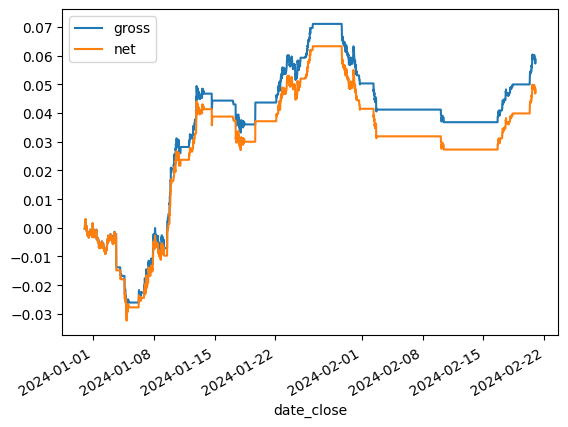

In [436]:
# taken from https://hyperliquid.gitbook.io/hyperliquid-docs/trading/fees
# assuming lowest volume tier
fee = 0.00035
slippage = 0.0005

# todo: add funding for both btc and sol
trades["date"] = trades.index

# per trade, there are twice the fee as well as slippage
trades["spread_fee"] = trades["pos"] * 1-(2*(fee+slippage))
returns["net"] = trades.spread_fee.pct_change() * trades.side/100

plt.yticks(np.arange(-0.1, 0.1, step=0.01))
returns["gross"].cumsum().plot()
returns["net"].cumsum().plot()
plt.legend()

# export results
df_res = pd.concat([trades["date"], returns["net"], returns["net"].cumsum()], axis=1)
df_res.columns = ["Date", "Returns", "Returns_Cumulative"]

df_res.to_csv("returns.csv")